<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


<h1><center>Final Assignment</center></h1>


> ***Note: Please ensure you follow the instructions outlined in the in the <a href="https://www.coursera.org/learn/supervised-machine-learning-regression/supplement/YGZt9/project-scenario">Project Scenario</a> section to complete this Final Assignment successfully.***


In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# 2. Load data
df = pd.read_csv("cars-2025.csv", encoding="ISO-8859-1")

# 3. Initial exploration (optional but useful)
print("Rows:", df.shape[0], "  Columns:", df.shape[1])
df.info()
df.head()

# -------------------------------------------------------------
# 4. DATA-CLEANING BLOCK — CREATE THE TRUE NUMERIC COLUMNS
#    (MUST run before any code that references cc_battery, etc.)
# -------------------------------------------------------------
def extract_numeric(val):
    """
    Pull the first numeric substring (with optional decimal point)
    out of any string. Returns float or NaN.
    """
    if pd.isna(val):
        return np.nan
    # Remove thousands separators, then search for digits/decimals
    cleaned = str(val).replace(",", "")
    match = re.search(r"[\d.]+", cleaned)
    return float(match.group()) if match else np.nan

# Map original object columns → new numeric columns
NUMERIC_MAP = {
    "CC/Battery Capacity":        "cc_battery",
    "HorsePower":                 "horse_power",
    "Total Speed":                "top_speed",
    "Performance(0 - 100 )KM/H":  "accel_0_100",
    "Cars Prices":                "price",
    "Seats":                      "seats",
    "Torque":                     "torque"
}

for old_name, new_name in NUMERIC_MAP.items():
    df[new_name] = df[old_name].apply(extract_numeric)



Rows: 1218   Columns: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company Names              1218 non-null   object
 1   Cars Names                 1218 non-null   object
 2   Engines                    1218 non-null   object
 3   CC/Battery Capacity        1215 non-null   object
 4   HorsePower                 1218 non-null   object
 5   Total Speed                1218 non-null   object
 6   Performance(0 - 100 )KM/H  1212 non-null   object
 7   Cars Prices                1218 non-null   object
 8   Fuel Types                 1218 non-null   object
 9   Seats                      1218 non-null   object
 10  Torque                     1217 non-null   object
dtypes: object(11)
memory usage: 104.8+ KB


In [2]:
# -------------------------------------------------------------
# 5. Now it is safe to examine missing values in the new columns
# -------------------------------------------------------------
print("\nMissing values in numeric columns:")
for col in NUMERIC_MAP.values():
    print(f"{col}: {df[col].isna().sum()}")


Missing values in numeric columns:
cc_battery: 5
horse_power: 0
top_speed: 0
accel_0_100: 6
price: 1
seats: 0
torque: 1



Basic statistics:
       horse_power         price    top_speed
count  1218.000000  1.217000e+03  1218.000000
mean    304.767652  1.367677e+05   216.467159
std     224.010915  7.048791e+05    53.051077
min      26.000000  4.000000e+03    80.000000
25%     150.000000  2.800000e+04   180.000000
50%     250.000000  4.200000e+04   200.000000
75%     400.000000  7.000000e+04   250.000000
max    2488.000000  1.800000e+07   500.000000


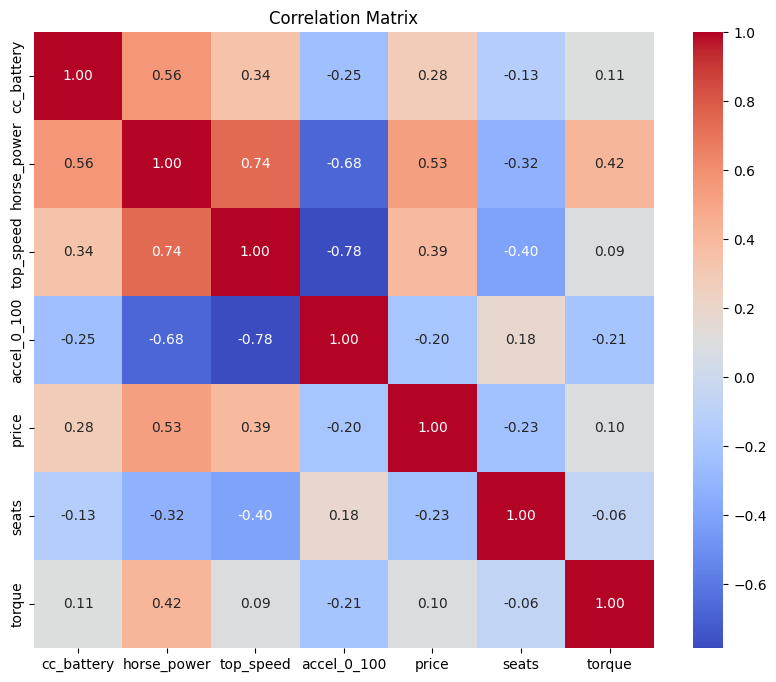

In [3]:
# 6. Quick descriptive stats on selected numeric features
print("\nBasic statistics:")
print(df[["horse_power", "price", "top_speed"]].describe())

# 7. Correlation matrix on numeric data (drop rows with any NaNs)
numeric_cols = list(NUMERIC_MAP.values())
corr_data = df[numeric_cols].dropna(how="any")

if not corr_data.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data.corr(), cmap="coolwarm", annot=True, fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()
else:
    print("No complete rows available for correlation analysis.")

# 8. Continue with train/test split, preprocessing pipeline,
#    cross-validation, etc. using the numeric + categorical columns

In [4]:
# 9. Define feature columns
num_cols = ["cc_battery", "horse_power", "top_speed", "accel_0_100", "seats", "torque"]
cat_cols = ["Company Names", "Engines", "Fuel Types"]

# 10. Prepare modeling dataset
df_model = df[num_cols + cat_cols + ["price"]].dropna(subset=["price"])

# 11. Split features and target
X = df_model[num_cols + cat_cols]
y = df_model["price"]


In [5]:
# 12. Build preprocessing pipelines
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# 13. Combine preprocessing steps
preprocessor = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


In [6]:
# 14. Define models to compare
models = {
    "OLS": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000)
}

# 15. Train and evaluate models using cross-validation
results = {}
for name, reg in models.items():
    pipe = Pipeline([("prep", preprocessor), ("reg", reg)])
    scores = cross_val_score(pipe, X, y, cv=10, scoring="neg_root_mean_squared_error")
    rmse = -scores.mean()
    results[name] = rmse
    print(f"{name}: mean RMSE = {rmse:,.0f}")


OLS: mean RMSE = 536,545
Ridge: mean RMSE = 395,537
Lasso: mean RMSE = 540,805


In [7]:
# 16. Select best model and train on full dataset
best_model = min(results, key=results.get)
print(f"Best model: {best_model}")

# 17. Train-test split for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 18. Fit final model
final_pipeline = Pipeline([("prep", preprocessor), ("reg", models[best_model])])
final_pipeline.fit(X_train, y_train)

# 19. Make predictions and evaluate
y_pred = final_pipeline.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
final_r2 = r2_score(y_test, y_pred)

print(f"Final {best_model} RMSE: {final_rmse:,.0f}")
print(f"Final {best_model} R²: {final_r2:.3f}")


Best model: Ridge
Final Ridge RMSE: 201,788
Final Ridge R²: 0.547


In [8]:
# rebuild models dictionary so every value is a full Pipeline
models = {
    "OLS":   Pipeline([("prep", preprocessor), ("reg", LinearRegression())]),
    "Ridge": Pipeline([("prep", preprocessor), ("reg", Ridge(alpha=1.0))]),
    "Lasso": Pipeline([("prep", preprocessor), ("reg", Lasso(alpha=0.001, max_iter=10000))])
}

results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    results.append({
        "Model": name,
        "R2_Test": r2_score(y_test, preds),
        "MAE": mean_absolute_error(y_test, preds),
        "RMSE": np.sqrt(mean_squared_error(y_test, preds))
    })

df_results = (pd.DataFrame(results)
              .set_index("Model")
              .sort_values("R2_Test", ascending=False))
print(df_results)


        R2_Test           MAE           RMSE
Model                                       
Ridge  0.546563  85989.067323  201788.060828
OLS    0.386619  96862.507289  234694.139689
Lasso  0.378072  98086.904668  236323.675343


In [9]:
# ────────────────────────────────────────────────────────
# After printing df_results, select and assign your best pipeline
# ────────────────────────────────────────────────────────

# 1. Identify the best model name (highest R²)
best_model_name = df_results.index[0]

# 2. Rebuild the full pipeline for that model
models = {
    "OLS":   Pipeline([("prep", preprocessor), ("reg", LinearRegression())]),
    "Ridge": Pipeline([("prep", preprocessor), ("reg", Ridge(alpha=1.0))]),
    "Lasso": Pipeline([("prep", preprocessor), ("reg", Lasso(alpha=0.001, max_iter=10000))])
}
best = models[best_model_name]

# 3. Fit the best pipeline
best.fit(X_train, y_train)

# 4. Extract coefficients
estimator = best.named_steps["reg"]
coef       = estimator.coef_
feat_names = best.named_steps["prep"].get_feature_names_out()

# 5. Build and display the coefficient DataFrame
import pandas as pd
coef_df = (
    pd.DataFrame({"feature": feat_names, "coef": coef})
      .sort_values("coef", key=abs, ascending=False)
      .head(15)
)
print(f"Best model: {best_model_name}")
print(coef_df)

Best model: Ridge
                                              feature          coef
212            cat__Engines_2.6L Wankel Rotary Engine  2.124066e+06
11                         cat__Company Names_Bugatti  2.100236e+06
299                  cat__Engines_8.0L Quad-Turbo W16  2.100236e+06
203                     cat__Engines_2.5L Turbo Diese -7.845623e+05
350                                  cat__Engines_V10 -4.646338e+05
34                     cat__Company Names_ROLLS ROYCE -4.456167e+05
351                                  cat__Engines_V12  3.848892e+05
274                          cat__Engines_4.0L,DIESEL  3.203968e+05
349                 cat__Engines_Twin-Turbo V6 Hybrid -2.898085e+05
42                           cat__Company Names_Volvo -2.896530e+05
38                           cat__Company Names_Tesla -2.815553e+05
342                      cat__Engines_Supercharged V8 -2.750570e+05
287        cat__Engines_6.2L Supercharged V8 Gasoline -2.739345e+05
270  cat__Engines_4.0L Twin-Tu

Copyright @ IBM Corporation. All rights reserved.
